In [2]:
import utilities as utils

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



    Last Execution: 2022-04-10 13:27:54.204473
    python:	3.8.5

    	fastai:		2.5.6
    	matplotlib:	3.5.1
    	numpy:		1.19.5
    	pandas:		1.4.1
    	seaborn:	0.11.2
    	sklearn:	1.0.2
    	torch:		1.11.0+cu102
    	yellowbrick:	1.4
    	imblearn:	0.9.0
    


In [3]:
data_path_1: str = './synthetic/'   
data_path_2: str = '../../../Data/phase1/'   
data_path_3: str = '../../../Data/phase2/'   

data_set_1: list = [ 'smote_application_30000.csv', 
                     'smote_application_upsample_to_majority.csv',
                     'smote_traffic_30_20_10.csv',
                     'smote_traffic_upsample_to_majority.csv']

data_set_2: list = [ 'Traffic_type_seed.csv', 'Application_type_seed.csv' ] 

data_set_3: list = [ 'Traffic_type_test.csv', 'Application_type_test.csv' ] 


file_path_1       = utils.get_file_path(data_path_1)
file_path_2       = utils.get_file_path(data_path_2)
file_path_3       = utils.get_file_path(data_path_3)
file_set_1 : list = list(map(file_path_1, data_set_1))
file_set_2 : list = list(map(file_path_2, data_set_2))
file_set_3 : list = list(map(file_path_3, data_set_3))

file_set : list   = file_set_1 + file_set_2 + file_set_3
data_set   : list = data_set_1 + data_set_2 + data_set_3
current_job: int  = 0

utils.data_set = data_set
utils.file_set = file_set

In [4]:
print(f'We will be using {len(file_set)} files:')
utils.pretty(file_set)

We will be using 8 files:
[   './synthetic/smote_application_30000.csv',
    './synthetic/smote_application_upsample_to_majority.csv',
    './synthetic/smote_traffic_30_20_10.csv',
    './synthetic/smote_traffic_upsample_to_majority.csv',
    '../../../Data/phase1/Traffic_type_seed.csv',
    '../../../Data/phase1/Application_type_seed.csv',
    '../../../Data/phase2/Traffic_type_test.csv',
    '../../../Data/phase2/Application_type_test.csv']


In [5]:
smote_balanced_application_dataset_labels_30_30_30 = utils.examine_dataset(1)
smote_balanced_application_dataset_labels_equal = utils.examine_dataset(2)
smote_balanced_traffic_labels_dataset_30_20_10 = utils.examine_dataset(3)
smote_balanced_traffic_labels_dataset_equal = utils.examine_dataset(4)
baseline_traffic_seed = utils.examine_dataset(5)
baseline_application_seed = utils.examine_dataset(6)
baseline_traffic_test = utils.examine_dataset(7)
baseline_application_test = utils.examine_dataset(8)

Dataset 1/8: We now look at ./synthetic/smote_application_30000.csv


Loading Dataset: ./synthetic/smote_application_30000.csv
	To Dataset Cache: ./cache/smote_application_30000.csv.pickle


        File:				./synthetic/smote_application_30000.csv  
        Job Number:			1
        Shape:				(240000, 64)
        Samples:			240000 
        Features:			64
    
Dataset 2/8: We now look at ./synthetic/smote_application_upsample_to_majority.csv


Loading Dataset: ./synthetic/smote_application_upsample_to_majority.csv
	To Dataset Cache: ./cache/smote_application_upsample_to_majority.csv.pickle


        File:				./synthetic/smote_application_upsample_to_majority.csv  
        Job Number:			2
        Shape:				(384160, 64)
        Samples:			384160 
        Features:			64
    
Dataset 3/8: We now look at ./synthetic/smote_traffic_30_20_10.csv


Loading Dataset: ./synthetic/smote_traffic_30_20_10.csv
	To Dataset Cache: ./cache/smote_traffic_30_20_10.csv.pickle


        File:				./synthetic/smo

In [21]:
smote_balanced_application_30_30_30 : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(smote_balanced_application_dataset_labels_30_30_30, ['Traffic Type']), 'Application_Dataset_30_30_30')
smote_balanced_application_majority : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(smote_balanced_application_dataset_labels_equal, ['Traffic Type']), 'Application_Dataset_majority')
smote_balanced_traffic_30_20_10     : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(smote_balanced_traffic_labels_dataset_30_20_10, ['Application Type']), 'Traffic_Dataset_30_20_10')
smote_balanced_traffic_majority     : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(smote_balanced_traffic_labels_dataset_equal, ['Application Type']), 'Traffic_Dataset_majority')
baseline_traffic_seed               : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_traffic_seed, ['Application Type']), 'Traffic_Dataset_seed')
baseline_application_seed           : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_application_seed, ['Traffic Type']), 'Application_Dataset_seed')
baseline_traffic_test               : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_traffic_test, ['Application Type']), 'Traffic_Dataset_test')
baseline_application_test           : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_application_test, ['Traffic Type']), 'Application_Dataset_test')

X_test_traffic, y_test_traffic = utils.extract_validation_set(baseline_traffic_test['Dataset'], "Traffic Type")

X_test_application, y_test_application = utils.extract_validation_set(baseline_application_test['Dataset'], "Application Type")


        Shape:				(240000, 63)
        Samples:			240000 
        Features:			63
    

        Shape:				(384160, 63)
        Samples:			384160 
        Features:			63
    

        Shape:				(60000, 63)
        Samples:			60000 
        Features:			63
    

        Shape:				(277977, 63)
        Samples:			277977 
        Features:			63
    

        Shape:				(115670, 63)
        Samples:			115670 
        Features:			63
    

        Shape:				(113620, 63)
        Samples:			113620 
        Features:			63
    

        Shape:				(1950, 63)
        Samples:			1950 
        Features:			63
    

        Shape:				(4000, 63)
        Samples:			4000 
        Features:			63
    


In [8]:
def run_shallow_learning_experiment(df: utils.pd.DataFrame, name: str, target_label: str, classifier, param_grid: str, split=0.2, categorical : list = ['Protocol'], leave_out: list = [], validation_data: utils.pd.DataFrame = None) -> utils.Model_data:
    '''
        Run binary classification using a shallow learning model
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    categorical_features: list = []
    untouched_features  : list = []

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = utils.tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # extract the name from the path
    p = utils.pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    pipe = utils.Pipeline([
    ('scaler', utils.StandardScaler()),
    ('selector', utils.VarianceThreshold()),
    ('classifier', classifier)
    ])
    pipe.fit(X_train, y_train)
    model = utils.GridSearchCV(pipe, param_grid, cv=3).fit(X_train, y_train)
    prediction = model.predict(X_test)
    prediction_prob = model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')

   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: utils.Model_data = utils.Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, name)

    
    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

In [88]:
def extract_validation_set(df: utils.pd.DataFrame, target_label: str, categorical : list = ['Protocol'], leave_out: list = []):
    '''
        Run binary classification using a shallow learning model
        returns the 10-tuple Model_data
    '''
    dep_var: str = target_label

    categorical_features: list = []
    untouched_features  : list = []

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=.99, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = utils.tabular_learner(dls)
    classes : list = list(model.dls.vocab)

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    
    return X_test, y_test

In [92]:
model = run_shallow_learning_experiment(baseline_traffic_seed['Dataset'], "30,20,10", "Traffic Type", utils.XGBClassifier(), {"classifier__n_estimators": [5,10]})

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:26:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:27:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for 30,20,10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18516
           1       0.97      0.93      0.95       138
           2       0.99      0.99      0.99      4480

    accuracy                           1.00     23134
   macro avg       0.99      0.97      0.98     23134
weighted avg       1.00      1.00      1.00     23134

	Accuracy: 0.9960231693611135

	F1: 0.9960153810560756

	AUC: 0.9950656065563899

	Mathew's Correlation: 0.9876243457833098



In [77]:
#X_test_traffic = baseline_traffic_seed['Dataset'].iloc[:,:-1]
#y_test_traffic = baseline_traffic_seed['Dataset'].iloc[:,-1]
#y_test_traffic = y_test_traffic.replace('Tor',2)
#y_test_traffic = y_test_traffic.replace('VPN',0)
#y_test_traffic = y_test_traffic.replace('Regular',1)

In [93]:
X_test_traffic, y_test_traffic = extract_validation_set(baseline_traffic_test['Dataset'], "Traffic Type")
prediction = model[1].predict(X_test_traffic)
prediction_prob = model[1].predict_proba(X_test_traffic)
report = utils.classification_report(y_test_traffic, prediction)
print(report)
print(f'\tAccuracy: {utils.accuracy_score(y_test_traffic, prediction)}\n')
print(f'\tF1: {utils.f1_score(y_test_traffic, prediction, average="weighted")}\n')
print(f'\tAUC: {utils.roc_auc_score(y_test_traffic, prediction_prob, multi_class="ovr")}\n')
print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test_traffic, prediction)}\n')

              precision    recall  f1-score   support

           0       0.51      0.71      0.59       645
           1       0.62      0.80      0.70       641
           2       0.92      0.30      0.45       644

    accuracy                           0.60      1930
   macro avg       0.68      0.60      0.58      1930
weighted avg       0.68      0.60      0.58      1930

	Accuracy: 0.6031088082901555

	F1: 0.5824215570438512

	AUC: 0.7774529731483998

	Mathew's Correlation: 0.4300526324820424



In [14]:
def visualize_side_by_side(
    model_datum: list,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = utils.visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True',
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = utils.plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    utils.plt.tight_layout()

    return (fig, ax)

In [15]:
def train_and_evaluate_n_classifiers(df: utils.pd.DataFrame, classifiers: list, target_label: str, classifier_names: list, shallow_classifiers: list, chart_title : str, boost_param_grid : str, res_results: dict) -> list:
    model_results : list = []
    for i, classifier in enumerate(classifiers):
        if classifier_names[i] in shallow_classifiers:
            model_results.append(run_shallow_learning_experiment(df, classifier_names[i],target_label, classifier, boost_param_grid[i]))
        else:
            
            res_results[0]['results'] = classifier
            model = res_results[0]['results']
            model_results.append(model)
            prediction = model[1].predict(model[5])
            res_results.pop(0)
            df_1 = logger_1.df
            df_1
            fig, ax = utils.plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
            df_1.plot(x='epoch', y=['accuracy', 'balanced_accuracy_score'], ax=ax[0][0])
            df_1.plot(x='epoch', y=['roc_auc_score', 'matthews_corrcoef'], ax=ax[0][1])
            df_1.plot(x='epoch', y=['precision_score', 'recall_score', 'f1_score'], ax=ax[1][0])
            grapher_1.plot_graph(ax=ax[1][1])
            
    visualize_side_by_side(model_results, chart_title, classifier_names, shape=(2,3), size=(20,10))
    visualize_side_by_side(model_results, chart_title, classifier_names, shape=(2,3), size=(20,10), plotting_function=utils.visualize_roc)
    visualize_side_by_side(model_results, chart_title, classifier_names, shape=(2,3), size=(20,10), plotting_function=utils.visualize_report)
    
    print("Condensed results:")
    for model in model_results:
        prediction = model[1].predict(model[5])
        prediction_prob = model[1].predict_proba(model[5])
        print(f'Results for {model[0]}. Acc: {utils.accuracy_score(model[6], prediction)}, F1: {utils.f1_score(model[6], prediction, average="weighted")}, AUC: {utils.roc_auc_score(model[6], prediction_prob, multi_class="ovr")}, MCC: {utils.matthews_corrcoef(model[6], prediction)}')

    return model_results

In [64]:
#xgb_param_grid = {
#        "classifier__n_estimators": utils.np.arange(1, 250, 25),
#        'classifier__max_depth':range(1, 5), 'classifier__min_child_weight':range(1,6,2),
#        "classifier__scale_pos_weight": utils.np.linspace(0, 1, 10),
#        'classifier__gamma':[i/10.0 for i in range(0,5)],
#        'classifier__subsample':[i/10.0 for i in range(6,10)], 'classifier__colsample_bytree':[i/10.0 for i in range(6,10)],
#        'classifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#        'classifier__reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
#}
boost_param_grid = {
        "classifier__n_estimators": utils.np.arange(1, 250, 25),
        'classifier__max_depth':range(1, 5), 'classifier__min_child_weight':range(1,6,2),
        'classifier__subsample':[i/10.0 for i in range(6,10)], 'classifier__colsample_bytree':[i/10.0 for i in range(6,10)],
        'classifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
        'classifier__reg_alpha':[0, 0.001, 0.005, 0.01, 0.05], 
}
rf_param_grid = {
        'classifier__n_estimators': utils.np.arange(1, 250, 25),
        'classifier__max_features': ['auto', 'sqrt'],
        'classifier__max_depth': [int(x) for x in utils.np.linspace(10, 110, num = 11)],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
}

# Sample Experiment using small parameters for testing

Better model found at epoch 0 with f1_score value: 0.9304073656734481.
Better model found at epoch 0 with f1_score value: 0.9292790685656286.
loss: 0.0536341518163681, accuracy:  98.58%
Layer sizes: [64, 5, 5, 3], length: 4
Number of residual blocks: 1
Residual locations:  [1]
Better model found at epoch 0 with f1_score value: 0.9391037804690624.
Better model found at epoch 0 with f1_score value: 0.9633495031202416.
loss: 0.06468700617551804, accuracy:  98.68%
Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18739
           1       0.98      0.96      0.97       275
           2       0.99      1.00      1.00      4510

    accuracy                           1.00     23524
   macro avg       0.99      0.99      0.99     23524
weighted avg       1.00      1.00      1.00     23524

	Accuracy: 0.9981295698010543

	F1: 0.9981273831238752

	AUC: 0.9970400938083376

	Mathew's Correlation: 0.9943079696759473



/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:24:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18739
           1       0.98      0.95      0.97       275
           2       0.99      0.99      0.99      4510

    accuracy                           1.00     23524
   macro avg       0.99      0.98      0.99     23524
weighted avg       1.00      1.00      1.00     23524

	Accuracy: 0.996174120047611

	F1: 0.996169455060611

	AUC: 0.9974562060262354

	Mathew's Correlation: 0.9883505338021586

Results for LightGBM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18739
           1       0.98      0.95      0.97       275
           2       0.99      0.99      

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model


/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model


/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier

/home/drake/miniconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



Condensed results:
Results for Random Forest. Acc: 0.9981295698010543, F1: 0.9981273831238752, AUC: 0.9970400938083376, MCC: 0.9943079696759473
Results for XGBoost. Acc: 0.996174120047611, F1: 0.996169455060611, AUC: 0.9974562060262354, MCC: 0.9883505338021586
Results for LightGBM. Acc: 0.9972793742560789, F1: 0.9972725783755522, AUC: 0.9990565107550969, MCC: 0.9917085135484123
Results for Traffic_Dataset_2_Tor_VPN_Regular. Acc: 0.9858442441761606, F1: 0.9858044031299145, AUC: 0.9916398024736175, MCC: 0.9566606847573449
Results for Traffic_Dataset_2_Tor_VPN_Regular. Acc: 0.9867794592756334, F1: 0.9866172388331458, AUC: 0.9795683366368588, MCC: 0.9594291960227498


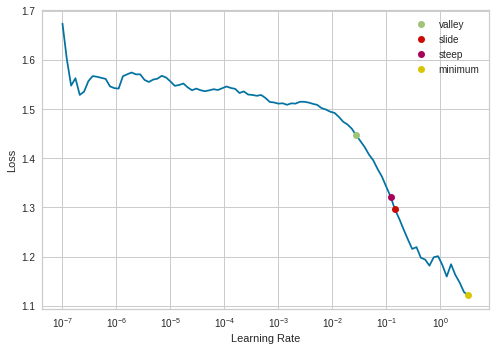

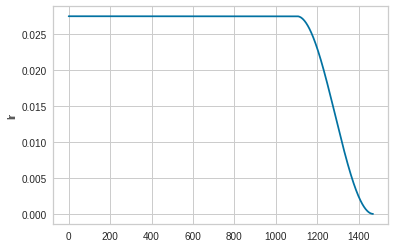

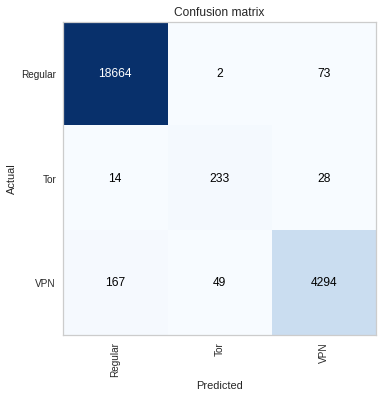

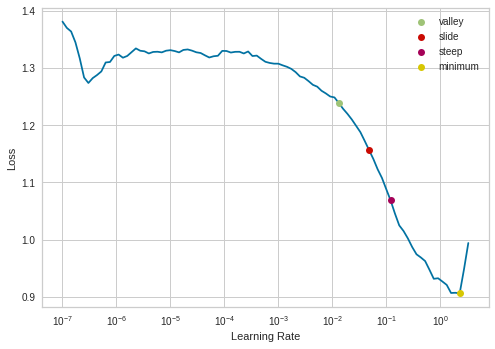

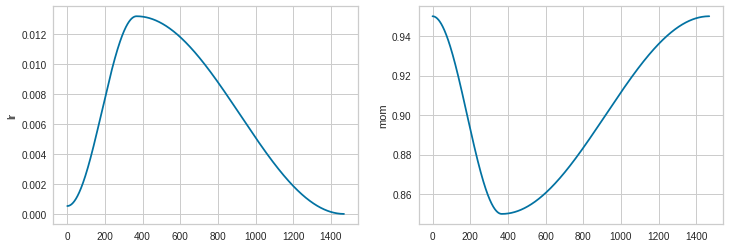

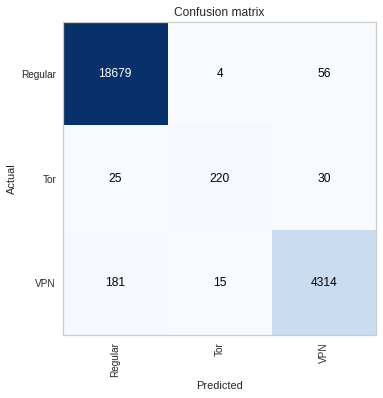

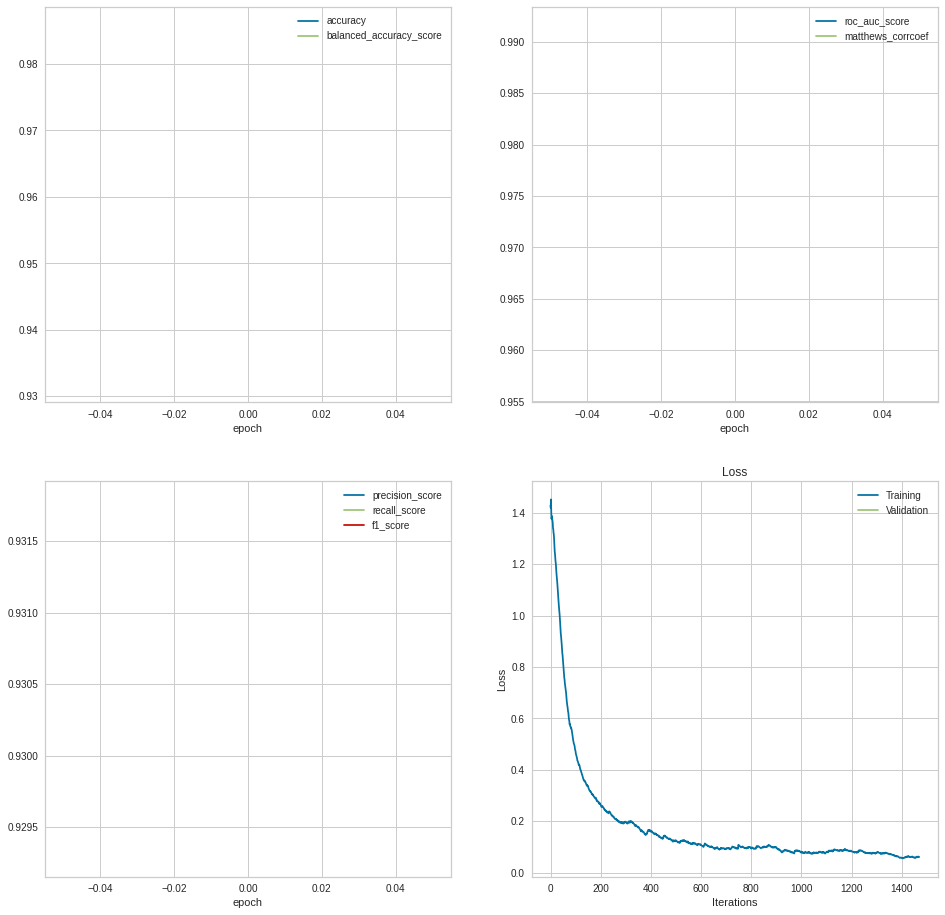

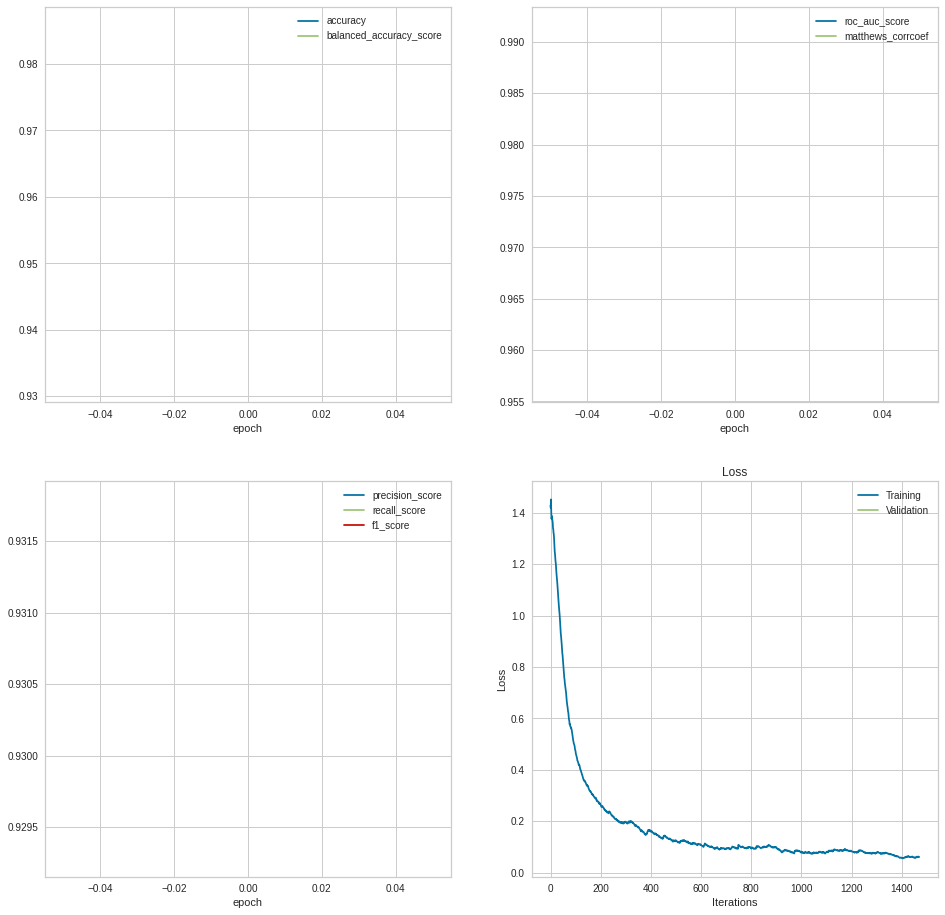

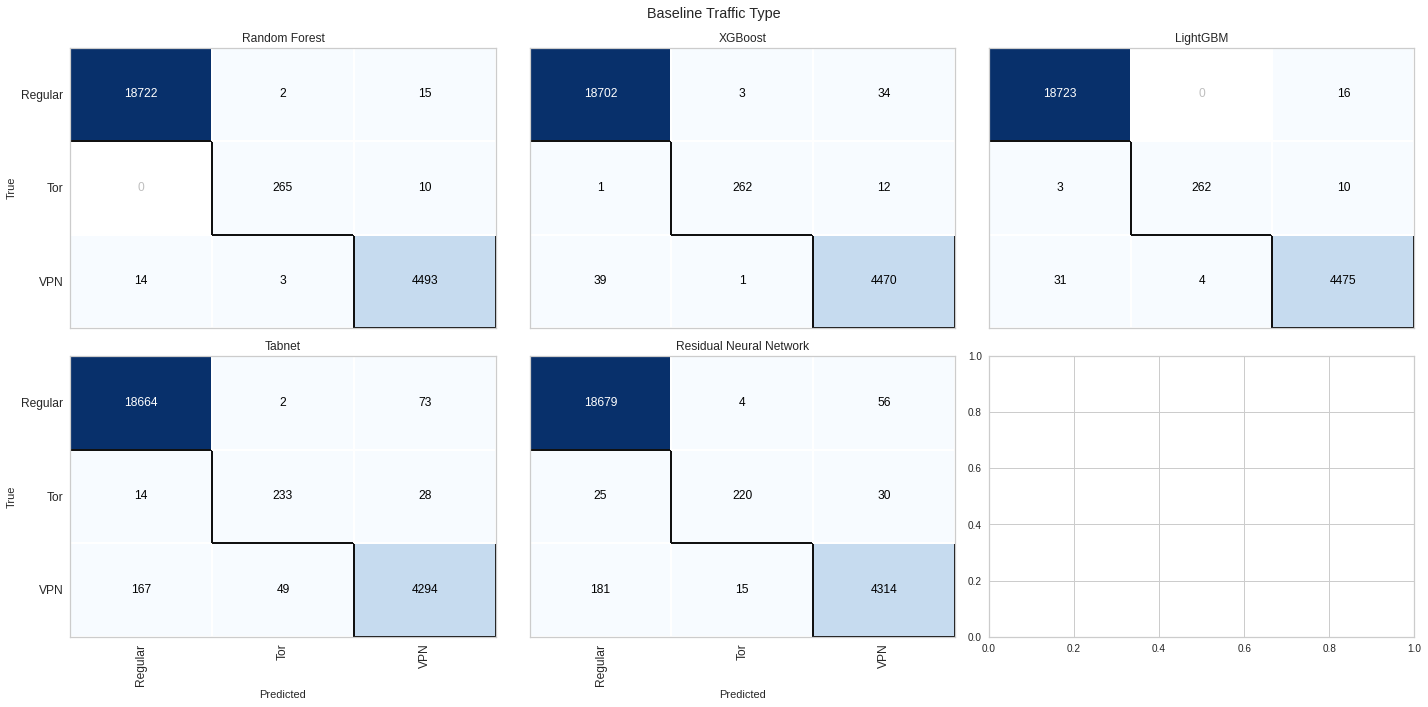

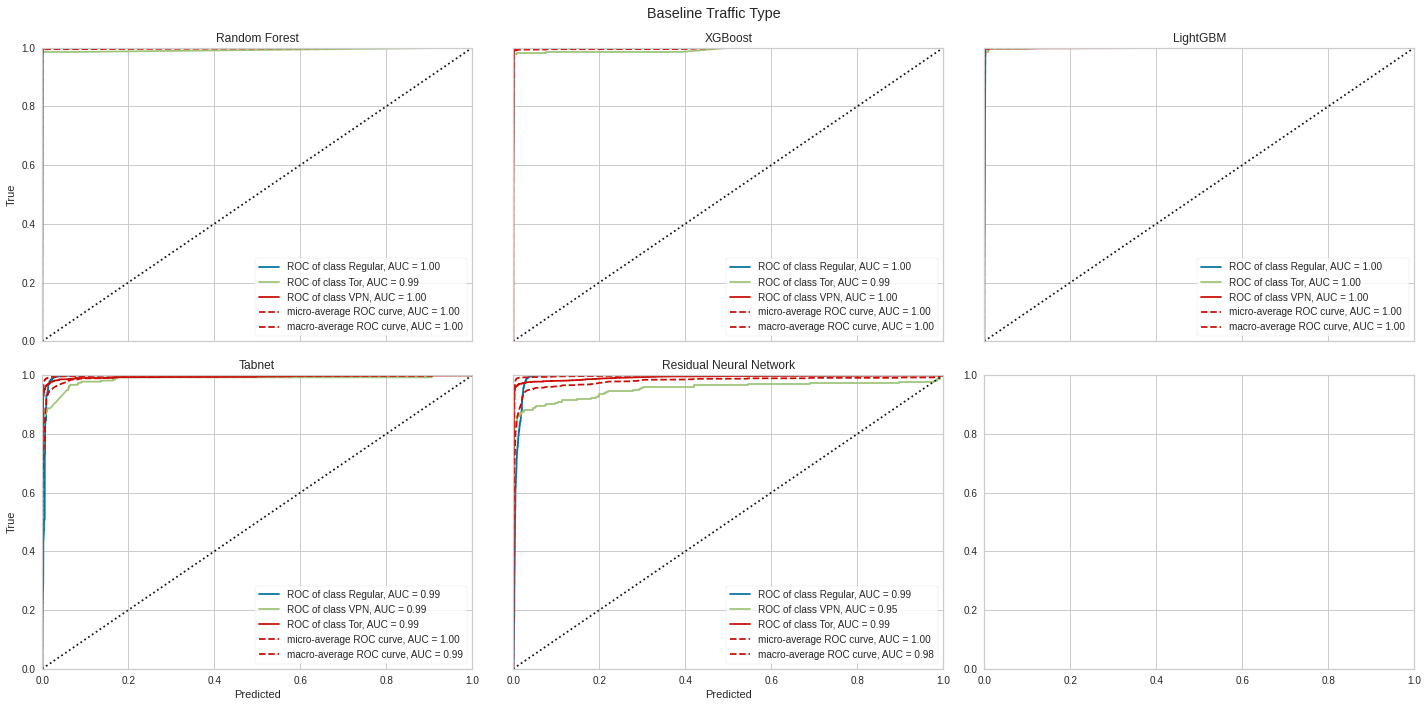

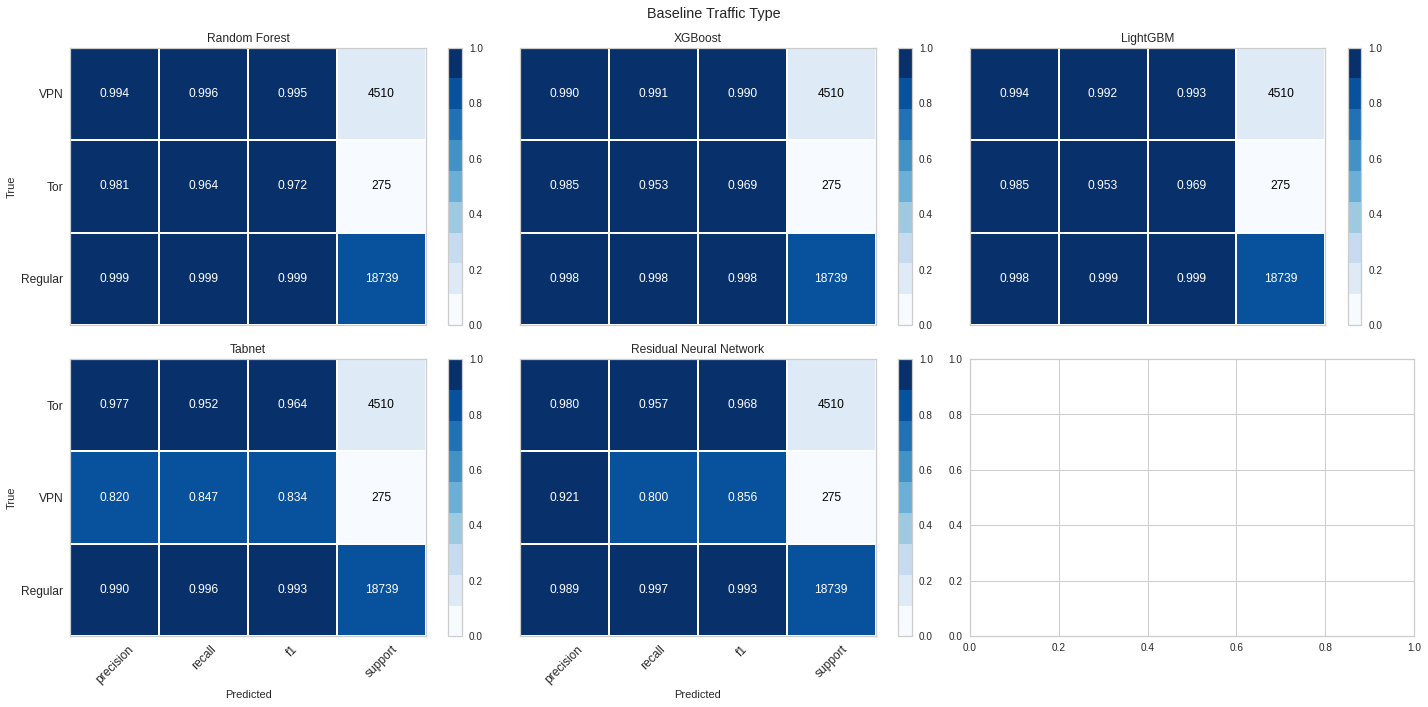

In [83]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [model_saver, logger_1, collector_1, grapher_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [model_saver_2, logger_2, collector_2, grapher_2]


test_param_grid = {
        "classifier__n_estimators": [5,10],
}

res_results = [{
                'tabnet=1_logger': logger_1, 
                'tabnet=1_collector': collector_1, 
                'tabnet=1_grapher': grapher_1,
            },
               {
                'residual=1_logger': logger_1, 
                'residual=1_collector': collector_1, 
                'residual=1_grapher': grapher_1,
            },]

classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(), 
                utils.run_tabnet_experiment(baseline_traffic_dataset['Dataset'], baseline_traffic_dataset['File'], 
                'Traffic Type', epochs=1, callbacks=callbacks_1, no_bar=True,),
                
                utils.run_residual_deep_nn_experiment(baseline_traffic_dataset['Dataset'], baseline_traffic_dataset['File'], 
               'Traffic Type', (5,5), epochs=1, callbacks=callbacks_2, no_bar=True,)]

classifier_names = ["Random Forest", "XGBoost", "LightGBM",  "Tabnet", "Residual Neural Network"]
shallow_classifiers = ["Random Forest", "XGBoost", "LightGBM"]
param_grids = [ test_param_grid, test_param_grid, test_param_grid ]

baseline_traffic_results = train_and_evaluate_n_classifiers(baseline_traffic_dataset['Dataset'], classifiers, "Traffic Type", classifier_names, shallow_classifiers,"Baseline Traffic Type", param_grids, res_results)